# To do:

 - Figure out how to signal injuries
 - Create model that generates minutes projections
 - Feature engineer a game count column, and optimize how many games you should be taken per dataset

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import duckdb
import warnings

import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import warnings
from datetime import datetime, timedelta
from haversine import haversine

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

categories = ['PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK']
con = duckdb.connect(database=":memory:")
now = str(datetime.now().date())
print(f"Today's date:", now)

Today's date: 2025-12-08


In [117]:
%run ./common_utils.ipynb

# Feature Engineering

In [ ]:
import math

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def travel_km_from_row(row):
    prev = row['PrevLocation']
    cur  = row['Location']
    # missing prev => first game => no travel
    if pd.isna(prev) or pd.isna(cur):
        return 0.0
    # same arena => 0
    if prev == cur:
        return 0.0
    # lookup coords
    prev_coords = arenas.get(prev)
    cur_coords  = arenas.get(cur)
    if not prev_coords or not cur_coords:
        # fallback if code not found
        return 0.0
    return haversine_km(prev_coords[0], prev_coords[1], cur_coords[0], cur_coords[1])

In [290]:
tgt_stat = "PTS"

df = pd.DataFrame()
df2 = pd.DataFrame()
for i in [2023, 2024, 2025]:
    df_actuals = pd.read_csv(f"../tables/{i}/parlay_actuals.csv")
    df = pd.concat([df, df_actuals])

    team_loc_indc = pd.read_csv(f"../tables/{i}/season_gamelogs.csv")[['Date', 'Team', 'Player', 'Team_type']]
    df2 = pd.concat([df2, team_loc_indc])

df['Date'] = pd.to_datetime(df.Date)
df2['Date'] = pd.to_datetime(df2.Date)

df = df.drop_duplicates(subset=['Date','Team','Player'])
df2 = df2.drop_duplicates(subset=['Date','Team','Player'])
df['Tms'] = df['game_id'].apply(lambda x: x.split("_")[1:3])
df['WrngTm'] = df.apply(lambda row: 0 if row['Team'] in row['Tms'] else 1, axis=1)
df['WrngOpp'] = df.apply(lambda row: 0 if row['Opp'] in row['Tms'] else 1, axis=1)
df = df[(df.WrngTm == 0) & (df.WrngOpp == 0)]
df = df.merge(df2, on=['Date', 'Team', 'Player'])
df = df.sort_values(['Player', 'Date'])

# Encode string cols
team_encoder = LabelEncoder()
team_encoder.fit(pd.concat([df["Team"], df["Opp"]], axis=0))
df["Team"] = team_encoder.transform(df["Team"])
df["Opp"] = team_encoder.transform(df["Opp"])

player_encoder = LabelEncoder()
df["Player"] = player_encoder.fit_transform(df["Player"])

team_type_encoder = LabelEncoder()
df['Team_type'] = team_type_encoder.fit_transform(df['Team_type'])

# Location based features
df["PrevOpp"] = df.groupby("Player")["Opp"].shift(1)
df["DaysLstGm"] = (df.groupby("Player")["Date"].diff().dt.days).fillna(0).astype(int)
df['Location'] = df.apply(lambda r: r['Team'] if r['Team_type'] == 'Home' else r['Opp'], axis=1)
df['PrevLocation'] = df.groupby('Player')['Location'].shift(1).fillna(31)
df['travel_km'] = df.apply(travel_km_from_row, axis=1).fillna(0)
df['travel_hours'] = df['travel_km'] / 800.0      # approximate flight hours
df['is_long_trip'] = (df['travel_km'] > 1500).astype(int)
df['same_arena'] = (df['PrevLocation'] == df['Location']).astype(int)

stat_cols = []
for stat in categories:
    for col in [f'Off_{stat}', f'Off_L5_{stat}', f'Def_{stat}', f'Def_L5_{stat}']:
        stat_cols.append(col)

final_cols = ['Date', 'Team', 'Team_type', 'B2B', 'Player', 'Opp', 
              'DaysLstGm', 'travel_km', 'travel_hours', 'PrevLocation', 'is_long_trip', 'same_arena', 
              tgt_stat] + stat_cols
df = df[final_cols].fillna(0)

df

,Date,Team,Team_type,B2B,Player,Opp,DaysLstGm,travel_km,travel_hours,PrevLocation,is_long_trip,same_arena,PTS,Off_PTS,Off_L5_PTS,Def_PTS,Def_L5_PTS,Off_AST,Off_L5_AST,Def_AST,Def_L5_AST,Off_REB,Off_L5_REB,Def_REB,Def_L5_REB,Off_PR,Off_L5_PR,Def_PR,Def_L5_PR,Off_PA,Off_L5_PA,Def_PA,Def_L5_PA,Off_RA,Off_L5_RA,Def_RA,Def_L5_RA,Off_PRA,Off_L5_PRA,Def_PRA,Def_L5_PRA,Off_TPM,Off_L5_TPM,Def_TPM,Def_L5_TPM,Off_STL,Off_L5_STL,Def_STL,Def_L5_STL,Off_BLK,Off_L5_BLK,Def_BLK,Def_L5_BLK,Off_STL_BLK,Off_L5_STL_BLK,Def_STL_BLK,Def_L5_STL_BLK
393,2023-10-26,16,1,0,0,22,0,0.0,0.0,31.0,0,0,0,0.000000,0.000000,5.000000,5.0,0.000000,0.000000,3.000000,3.0,0.000000,0.000000,4.000000,4.0,0.000000,0.000000,9.000000,9.0,0.000000,0.0,8.000000,8.0,0.000000,0.00,7.000000,7.0,0.000000,0.000000,12.000000,12.0,0.000000,0.000000,1.000000,1.0,0.000000,0.0,2.000000,2.0,0.00,0.00,0.000000,0.0,0.000,0.0,2.000000,2.0
981,2023-10-29,16,1,0,0,0,3,0.0,0.0,22.0,0,0,7,3.500000,3.500000,16.833333,15.4,0.000000,0.000000,3.500000,3.0,0.500000,0.500000,3.500000,3.2,4.000000,4.000000,20.333333,18.6,3.500000,3.5,20.333333,18.4,0.500000,0.50,7.000000,6.2,4.000000,4.000000,23.833333,21.6,1.000000,1.000000,2.500000,2.6,0.000000,0.0,0.833333,1.0,0.00,0.00,0.166667,0.2,0.000,0.0,1.000000,1.2
1216,2023-10-30,16,1,0,0,15,1,0.0,0.0,0.0,0,0,0,2.333333,2.333333,12.800000,12.8,0.666667,0.666667,3.000000,3.0,0.333333,0.333333,3.800000,3.8,2.666667,2.666667,16.600000,16.6,3.000000,3.0,15.800000,15.8,1.000000,1.00,6.800000,6.8,3.333333,3.333333,19.600000,19.6,0.666667,0.666667,2.400000,2.4,0.000000,0.0,0.800000,0.8,0.00,0.00,1.200000,1.2,0.000,0.0,2.000000,2.0
1613,2023-11-01,16,0,0,0,27,2,0.0,0.0,15.0,0,0,2,2.250000,2.250000,11.125000,11.4,0.750000,0.750000,2.125000,2.0,0.500000,0.500000,6.375000,6.0,2.750000,2.750000,17.500000,17.4,3.000000,3.0,13.250000,13.4,1.250000,1.25,8.500000,8.0,3.500000,3.500000,19.625000,19.4,0.500000,0.500000,1.875000,2.0,0.000000,0.0,1.125000,1.2,0.00,0.00,0.625000,1.0,0.000,0.0,1.750000,2.2
2132,2023-11-03,16,1,0,0,19,2,0.0,0.0,27.0,0,0,0,1.800000,1.800000,17.285714,18.2,0.600000,0.600000,3.714286,3.6,0.400000,0.400000,4.571429,3.8,2.200000,2.200000,21.857143,22.0,2.400000,2.4,21.000000,21.8,1.000000,1.00,8.285714,7.4,2.800000,2.800000,25.571429,25.6,0.400000,0.400000,2.000000,2.6,0.000000,0.0,1.285714,1.2,0.00,0.00,0.428571,0.2,0.000,0.0,1.714286,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67312,2025-11-29,18,0,0,712,9,5,0.0,0.0,3.0,0,0,25,21.777778,20.400000,16.562500,12.8,4.000000,3.800000,2.437500,2.0,6.125000,4.800000,5.625000,5.0,27.222222,25.200000,22.187500,17.8,25.777778,24.2,19.000000,14.8,9.444444,8.60,8.062500,7.0,31.222222,29.000000,24.625000,19.8,0.000000,0.000000,0.000000,0.0,2.285714,1.6,0.875000,0.6,1.25,1.25,0.312500,0.4,2.625,2.2,1.187500,1.0
51314,2025-01-30,14,1,0,713,10,0,0.0,0.0,31.0,0,0,0,0.000000,0.000000,13.171717,20.4,0.000000,0.000000,2.979798,4.8,0.000000,0.000000,3.818182,6.0,0.000000,0.000000,16.989899,26.4,0.000000,0.0,16.151515,25.2,0.000000,0.00,6.797980,10.8,0.000000,0.000000,19.969697,31.2,0.000000,0.000000,1.818182,1.8,0.000000,0.0,1.010101,1.8,0.00,0.00,0.373737,0.6,0.000,0.0,1.383838,2.4
52032,2025-02-03,14,1,0,713,26,4,0.0,0.0,10.0,0,0,0,0.000000,0.000000,13.696078,8.8,0.000000,0.000000,3.225490,2.6,0.000000,0.000000,3.833333,3.2,0.000000,0.000000,17.529412,12.0,0.000000,0.0,16.921569,11.4,0.000000,0.00,7.058824,5.8,0.000000,0.000000,20.754902,14.6,0.000000,0.000000,1.970588,0.6,0.000000,0.0,1.147059,0.4,0.00,0.00,0.254902,0.0,0.000,0.0,1.401961,0.4
53057,2025-02-08,14,1,1,713,20,5,0.0,0.0,26.0,0,0,0,0.000000,0.000000,12.155963,15.2,0.000000,0.000000,2.697248,2.2,0.000000,0.000000,3.954128,5.6,0.000000,0.000000,16.110092,20.8,0.000000,0.0,14.853211,17.4,0.000000,0.00,6.651376,7.8,0.000000,0.000000,18.807339,23.0,0.000000,0.000000,

# Baseline Model

In [336]:
n = len(df)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]

print('Train:', len(train_df), '/ Validation:', len(val_df), '/ Test:', len(test_df))

feature_cols = [col for col in df.columns 
                if col not in ['Date', tgt_stat]]

X_train, y_train = train_df[feature_cols], train_df[tgt_stat]
X_val,   y_val   = val_df[feature_cols],   val_df[tgt_stat]
X_test,  y_test  = test_df[feature_cols],  test_df[tgt_stat]


model = XGBRegressor(
    enable_categorical=True,
    n_estimators=300,    # number of trees
    learning_rate=0.05,  # step size
    max_depth=6,         # complexity
    subsample=0.8,       # row sampling
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

Train: 47694 / Validation: 10220 / Test: 10221
RMSE: 4.7058588237735215
MAE: 3.325061082839966
R²: 0.7494543194770813


,feature,importance,pct
0,Off_L5_PTS,19339.912109,0.511443
1,Off_L5_PA,7292.524414,0.704294
2,Off_L5_PR,1112.447021,0.733712
3,Def_L5_PTS,918.211243,0.757994
4,Def_L5_PR,346.202545,0.767150
5,Off_PTS,327.900360,0.775821
6,Def_L5_PA,287.882751,0.783434
7,Def_L5_TPM,283.895111,0.790942
8,Def_L5_RA,258.354340,0.797774
9,Off_L5_AST,238.117340,0.804071


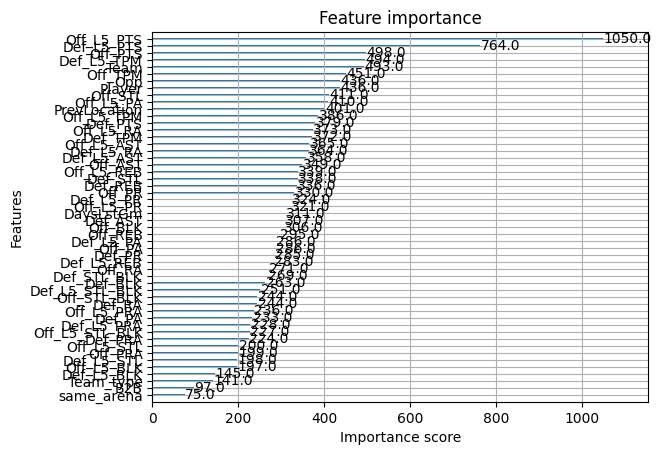

In [337]:
importance = model.get_booster().get_score(importance_type='gain')

# Convert to table
df_importance = (
    pd.DataFrame({
        'feature': list(importance.keys()),
        'importance': list(importance.values())
    })
    .sort_values(by='importance', ascending=False)
    .reset_index(drop=True)
)

df_importance['pct'] = df_importance.importance.cumsum() / df_importance.importance.sum()
display(df_importance[(df_importance.pct <= .85)])

xgb.plot_importance(model)
plt.show()

# Hyperparameter tuning

In [339]:
param_dist = {
    "n_estimators": randint(200, 2000),
    "learning_rate": uniform(0.01, 0.3),
    "max_depth": randint(3, 10),
    "min_child_weight": randint(1, 10),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0, 5),
    "reg_lambda": uniform(0, 5),
    "reg_alpha": uniform(0, 5)
}


random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=40,                # increase to 80+ for better tuning
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_val, y_val)

best_model = random_search.best_estimator_
print("Best params:", random_search.best_params_, "\n")

preds = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_test, preds))
print("R²:", r2_score(y_test, preds))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params: {'colsample_bytree': np.float64(0.8721230154351118), 'gamma': np.float64(2.2524962598477147), 'learning_rate': np.float64(0.013979488347959958), 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 976, 'reg_alpha': np.float64(0.07983126110107097), 'reg_lambda': np.float64(1.1544691281107449), 'subsample': np.float64(0.6964101864104046)} 

RMSE: 4.713213976293472
MAE: 3.3613967895507812
R²: 0.7486705183982849


In [356]:
pred_col = f'{tgt_stat}_Pred'
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
test_df['Date'] = pd.to_datetime(test_df.Date)
df_lines = df_lines[['Date', 'Team', 'Player', f'{tgt_stat}_line']]
test_df[pred_col] = preds
df_test = test_df.merge(df_lines, on=['Date', 'Team', 'Player'])
df_test = df_test[[c for c in df_test.columns if c != pred_col] + [pred_col]]
df_test['Diff'] = abs(df_test[f'{tgt_stat}_Pred'] - df_test[f'{tgt_stat}_line'])
df_test['Act_Res'] = np.where(df_test[tgt_stat] > df_test[f'{tgt_stat}_line'], 'O', 'U')
df_test['Pred_Res'] = np.where(df_test[pred_col] > df_test[f'{tgt_stat}_line'], 'O', 'U')
df_test['Correct'] = np.where(df_test['Act_Res'] == df_test['Pred_Res'], 1, 0)

print("Total Accuracy:", ((df_test.Correct == 1).sum() / df_test.shape[0]))
print((df_test.Correct == 1).sum(), "/", df_test.shape[0])
display(df_test[df_test.Diff <= rmse].sort_values('Diff', ascending=False).drop(['Diff', 'Correct', 'Act_Res', 'Pred_Res'], axis=1).head(15))

ValueError: You are trying to merge on int64 and object columns for key 'Team'. If you wish to proceed you should use pd.concat

# Today's predictions

In [344]:
df_gms = pd.read_csv(f"../tables/2025/nba_schedule.csv")
df_gms = df_gms[(df_gms.Date == now)]
df_mtch = df_gms[['AwayABV', 'HomeABV', 'AwayB2B', 'HomeB2B']]
df_mtch['Team_type'] = 'Home'
df_mtch = df_mtch.rename(columns={"AwayABV": "Team", "HomeABV": "Opp", "AwayB2B": "B2B"})[['Team', 'Opp', 'B2B', 'Team_type']]
df_mtch2 = df_mtch.copy().rename(columns={"Team": "Opp", "Opp": "Team", "HomeB2B": "B2B"})[['Team', 'Opp', 'B2B']]
df_mtch2['Team_type'] = 'Away'
df_mtch = pd.concat([df_mtch, df_mtch2])
df_mtch = df_mtch[['Team', 'Team_type']]

In [357]:
df_pred = pd.read_csv("../tables/2025/parlay_stats.csv")
df_pred['Date'] = pd.to_datetime(df_pred.Date)
for col in df_pred.select_dtypes(include='object').columns:
    df_pred[col] = df_pred[col].astype('category')
    
# Filter → then select feature columns
df_pred = df_pred[df_pred.Date == now][feature_cols]

# Predict
df_pred[f"{tgt_stat}_proj"] = best_model.predict(df_pred)
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[df_lines.Date == now][['Team', 'Player', f'{tgt_stat}_line']]
df_pred = df_pred.merge(df_lines, on=['Team', 'Player'])
df_pred['Diff'] = abs(df_pred[f'{tgt_stat}_proj'] - df_pred[f'{tgt_stat}_line'])

# print('Safe Bets')
# display(df_pred[(df_pred.Diff >= rmse)].drop('Diff', axis=1).sort_values('Team'))

print('Full')
for tm in df_pred.Team.unique():
    display(df_pred[(df_pred.Team == tm)].drop('Diff', axis=1).sort_values(f'Def_{tgt_stat}', ascending=False))

KeyError: "['Team_type', 'DaysLstGm', 'travel_km', 'travel_hours', 'PrevLocation', 'is_long_trip', 'same_arena'] not in index"